<a href="https://colab.research.google.com/github/panstenos/IMDB-Review-Sentiment-NLP-PyTorch/blob/main/NLP_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. LSTM

## 1. Data Collection

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
folder_dir = '/content/drive/MyDrive/Colab Notebooks/Getting started with PyTorch'
%cd folder_dir
!unzip archive.zip

[Errno 2] No such file or directory: 'folder_dir'
/content
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [3]:
import pandas as pd

file_path = os.path.join(folder_dir, 'IMDB Dataset.csv')
df = pd.read_csv(file_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Check for duplicates

In [4]:
df.duplicated().value_counts()

False    49582
True       418
Name: count, dtype: int64

In [5]:
df = df.drop_duplicates().reset_index(level=0, drop=True) # reset the index to make sure that the index values are continuous
df.duplicated().value_counts()

False    49582
Name: count, dtype: int64

In [6]:
df.sentiment.value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [7]:
df['sentiment'] = df['sentiment'].replace({'positive':1, 'negative':0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## 2. Tokenization and data Pipeline

In [20]:
%pip install torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.

In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# tokenizer
tokenizer = get_tokenizer('basic_english')

# vocabulary
texts, labels = list(df.review.values), list(df.sentiment.values)
def yield_tokens(texts):
  for text in texts:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(texts), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>']) # default for oov

In [10]:
from torch.nn.utils.rnn import pad_sequence
import torch

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
encoded_texts = [torch.tensor(text_pipeline(sentence)) for sentence in texts]

encoded_texts_pad = pad_sequence(encoded_texts, batch_first=True, padding_value=vocab['<pad>'])

In [11]:
from torch.utils.data import DataLoader, TensorDataset, random_split

labels_tensor = torch.tensor(labels)

dataset = TensorDataset(encoded_texts_pad, labels_tensor)
test_size = int(0.20 * len(dataset))
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

batch_size = 50
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

## 3. Modelling

In [ ]:
class LSTMClassifier(torch.nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMClassifier, self).__init__()
    self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
    self.lstm = torch.nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
    self.fc1 = torch.nn.Linear(2*hidden_dim, output_dim)

  def forward(self, text):
    x = self.embedding(text)
    lstm_out, (h, c) = self.lstm(x)
    h = torch.cat((h[-2], h[-1]), dim=1)
    x = self.fc1(h)
    return x

In [ ]:
torch.cuda.empty_cache()
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=32, hidden_dim=32, output_dim=1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model

LSTMClassifier(
  (embedding): Embedding(147158, 32)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
from tqdm.auto import tqdm
import time

In [ ]:
def train(model, train_loader, optimizer, criterion):
    correct = 0
    epoch_loss = 0
    total_samples = 0
    model.train()
    pbar = tqdm(train_loader, total=len(train_loader))

    for i, (x, y) in enumerate(pbar):
        text, label = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(text).squeeze()
        loss = loss_fn(outputs, label.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        y_pred = (outputs > 0).type(torch.long)
        correct += (y_pred == label).sum().item()
        total_samples += label.size(0) # label.size(0) = batch_size (for most of the epochs)
        accuracy = correct / total_samples

        pbar.set_postfix(ordered_dict={
          'batch': f"{int(i + 1)}/{len(train_loader)}",
          'train_accuracy': f"{accuracy * 100:.2f}%",
          'train_loss': f"{epoch_loss*train_loader.batch_size/total_samples:.4f}"
        }, refresh=True)
    pbar.close()
    return epoch_loss / len(train_loader), accuracy

In [ ]:
def evaluate(model, test_loader, criterion):
    correct = 0
    epoch_loss = 0
    total_samples = 0
    model.eval()
    pbar = tqdm(test_loader, total=len(test_loader))

    with torch.no_grad():
        for i, (x, y) in enumerate(pbar):
            text, label = x.to(device), y.to(device)
            outputs = model(text).squeeze()
            loss = criterion(outputs, label.float())
            epoch_loss += loss.item()
            y_pred = (outputs > 0).type(torch.long)
            correct += (y_pred == label).sum().item()
            total_samples += label.size(0)
            accuracy = correct / total_samples

            pbar.set_postfix(ordered_dict={
              'batch': f"{int(i + 1)}/{len(test_loader)}",
              'valid_accuracy': f"{accuracy * 100:.2f}%",
              'valid_loss': f"{epoch_loss*test_loader.batch_size/total_samples:.4f}"
            }, refresh=True)
    pbar.close()
    return epoch_loss / len(test_loader), accuracy

In [ ]:
num_epochs = 25
history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_acc = evaluate(model, test_loader, loss_fn)

    history.append([train_loss, valid_loss, train_acc, valid_acc])

    if train_acc > 0.99:
      print('\n More than 99.0% accuracy reached --> terminating training')
      break

Epoch 1/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 8/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 9/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 10/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 11/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 12/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 13/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 14/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 15/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 16/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 17/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 18/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 19/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 20/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 21/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 22/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 23/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 24/25


  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]


 More than 99.0% accuracy reached --> terminating training


In [ ]:
# Save the model state
torch.save(model.state_dict(), 'model_state.pth')

In [ ]:
# Load the model
torch.cuda.empty_cache()
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=32, hidden_dim=32, output_dim=1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('model.pth'))
model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'model.pth'

## 4. Model Evaluation

In [ ]:
history_df = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
history_df.to_csv('model_history.csv', index=False)
history_df

,train_loss,valid_loss,train_acc,valid_acc
0,0.654500,0.597291,0.605834,0.705627
1,0.604541,0.568722,0.683759,0.721662
2,0.634963,0.609299,0.650381,0.661860
3,0.510215,0.491980,0.766349,0.777733
4,0.432703,0.459919,0.816266,0.796692
5,0.379791,0.420326,0.848233,0.827551
6,0.333877,0.409697,0.870368,0.841771
7,0.391415,0.582066,0.845712,0.725494
8,0.394395,0.478103,0.830938,0.800827
9,0.335650,0.406143,0.864922,0.836527


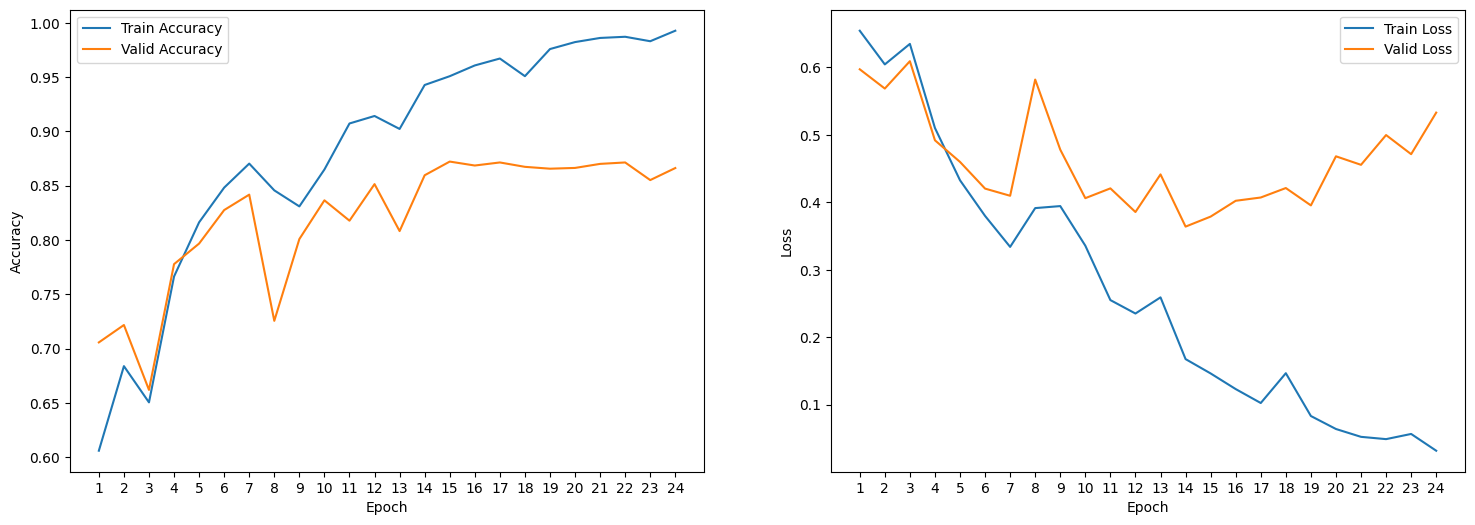

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['train_acc'], label='Train Accuracy')
ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_acc'], label='Valid Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax1.legend()

ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['train_loss'], label='Train Loss')
ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_loss'], label='Valid Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax2.legend()

fig.show()

## 5. Classify Custom Review

In [ ]:
def process_input_from_keyboard():
    input_sentence = input("Please enter a sentence: ")

    encoded_sentence = torch.tensor(text_pipeline(input_sentence))
    padded_encoded_sentence = pad_sequence([encoded_sentence], batch_first=True, padding_value=vocab['<pad>'])

    with torch.no_grad():  # Disable gradient computation
        output = model(padded_encoded_sentence.to(device))
        y_pred = (output > 0).type(torch.long)
        confidence = torch.sigmoid(torch.abs(output)).item()*100

    predicted_label = label_mapping(y_pred)
    print(f"This review is {predicted_label}. ({confidence:.2f}% confidence)")
def label_mapping(index):
    return "Positive" if index == 1 else "Negative"

process_input_from_keyboard()

Please enter a sentence: This movie was the best


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

# B. BERT

## 1. Data Collection

In [8]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## 2. Tokenization and Data Pipeline

In [9]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.review = dataframe.review
        self.targets = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, index):
        review = str(self.review[index])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(
            review,
            truncation='longest_first',
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids='pt'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
train_size = int(0.80 * df.shape[0])
train_df, test_df = df.iloc[:train_size,:], df.iloc[train_size:,:].reset_index()

batch_size = 30
train_loader, test_loader = DataLoader(CustomDataset(train_df, tokenizer, 512), batch_size=batch_size, shuffle=True), DataLoader(CustomDataset(test_df, tokenizer, 512), batch_size=batch_size, shuffle=False)

In [11]:
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## 3. Modelling

In [12]:
from transformers import BertModel

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1) # (768, 1) for bert-base, (1024, 1) for bert-large

    def forward(self, ids, mask, token_type_ids):
        hidden, output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [13]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [14]:
from tqdm.auto import tqdm

In [48]:
for data in train_loader:
  print(data['ids'].dim())
  print(data['targets'].dim())
  break

2
1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
def train(model, train_loader, optimizer, criterion):
  correct = 0
  epoch_loss = 0
  total_samples = 0
  model.train()
  pbar = tqdm(train_loader, total=len(train_loader))

  for i, data in enumerate(pbar):  # Use the pbar directly here
    if data['ids'].dim() == 2: # check if the dimension of the inputs is 2. If so, no unsqeezing is needed
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    elif data['ids'].dim() == 1: # if the values are 1D then add a first dimension: [1, max_len] -> [1, max_len], this will happen when batch_size = 1. Pytorch will return values as 1D
      ids = data['ids'].to(device, dtype = torch.long).unsqueeze(0)
      mask = data['mask'].to(device, dtype = torch.long).unsqueeze(0)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long).unsqueeze(0)
    targets = data['targets'].to(device, dtype = torch.float) # targets remain 1D

    optimizer.zero_grad()
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids).squeeze()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    y_pred = (outputs > 0).type(torch.long)
    correct += (y_pred == targets).sum().item()
    total_samples += targets.size(0)
    accuracy = correct / total_samples

    pbar.set_postfix(ordered_dict={
      'batch': f"{int(i + 1)}/{len(train_loader)}",
      'train_accuracy': f"{accuracy * 100:.2f}%",
      'train_loss': f"{epoch_loss*train_loader.batch_size/total_samples:.4f}"
    }, refresh=True)
  pbar.close()
  return epoch_loss / len(train_loader), accuracy

In [20]:
def evaluate(model, test_loader, criterion):
  correct = 0
  epoch_loss = 0
  total_samples = 0
  model.eval()
  pbar = tqdm(test_loader, total=len(test_loader))

  with torch.no_grad():
    for i, data in enumerate(pbar):
      if data['ids'].dim() == 2: # check if the dimension of the inputs is 2. If so, no unsqeezing is needed
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      elif data['ids'].dim() == 1: # if the values are 1D then add a first dimension: [1, max_len] -> [1, max_len], this will happen when batch_size = 1. Pytorch will return values as 1D
        ids = data['ids'].to(device, dtype = torch.long).unsqueeze(0)
        mask = data['mask'].to(device, dtype = torch.long).unsqueeze(0)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long).unsqueeze(0)
      targets = data['targets'].to(device, dtype = torch.float) # targets remain 1D

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids).squeeze()
      loss = criterion(outputs, targets)

      epoch_loss += loss.item()
      y_pred = (outputs > 0).type(torch.long)
      correct += (y_pred == targets).sum().item()
      total_samples += targets.size(0)
      accuracy = correct / total_samples

      pbar.set_postfix(ordered_dict={
        'batch': f"{int(i + 1)}/{len(test_loader)}",
        'valid_accuracy': f"{accuracy * 100:.2f}%",
        'valid_loss': f"{epoch_loss*test_loader.batch_size/total_samples:.4f}"
      }, refresh=True)
  pbar.close()
  return epoch_loss / len(test_loader), accuracy

In [22]:
num_epochs = 25
history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_acc = evaluate(model, test_loader, loss_fn)

    history.append([train_loss, valid_loss, train_acc, valid_acc])

    if train_acc > 0.99:
      print('\n More than 99.0% accuracy reached --> terminating training')
      break

Epoch 1/25


  0%|          | 0/1323 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

Epoch 2/25


  0%|          | 0/1323 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

Epoch 3/25


  0%|          | 0/1323 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

Epoch 4/25


  0%|          | 0/1323 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

Epoch 5/25


  0%|          | 0/1323 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]


 More than 99.0% accuracy reached --> terminating training


In [34]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/Getting started with PyTorch/Bert_IMDB_sentiment.pth'
torch.save(model.state_dict(), drive_path)

## 4. Model Evaluation

In [27]:
history_df = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
history_df.to_csv('model_history.csv', index=False)
history_df

,train_loss,valid_loss,train_acc,valid_acc
0,0.235293,0.171906,0.905130,0.934557
1,0.131581,0.166519,0.953687,0.942120
2,0.080496,0.176811,0.973251,0.943733
3,0.047308,0.219910,0.985957,0.941615
4,0.031496,0.260066,0.991050,0.939901


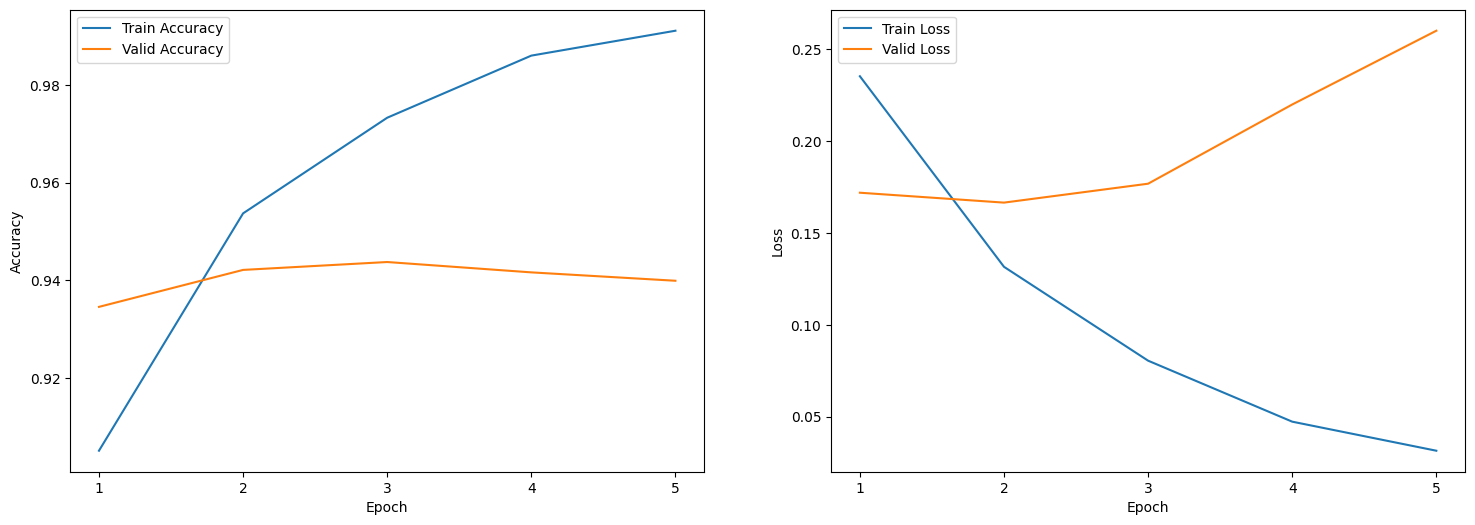

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['train_acc'], label='Train Accuracy')
ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_acc'], label='Valid Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax1.legend()

ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['train_loss'], label='Train Loss')
ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_loss'], label='Valid Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax2.legend()

fig.show()

## 5. Classify Custom Review

In [52]:
def process_input_from_keyboard():
    input_sentence = input("Please enter a review: ")

    print(f'Headline: {input_sentence}')

    def label_mapping(index):
        return 'possitive' if index == 1 else 'negative'

    input_sentence = " ".join(input_sentence.split())
    inputs = tokenizer.encode_plus(
        input_sentence,
        truncation='longest_first',
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_token_type_ids='pt'
    )

    if torch.tensor(inputs['input_ids'], dtype=torch.long).dim() == 2:
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
    elif torch.tensor(inputs['input_ids'], dtype=torch.long).dim() == 1:
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).unsqueeze(0)

    ids, mask, token_type_ids = ids.to(device, dtype=torch.long), mask.to(device, dtype=torch.long), token_type_ids.to(device, dtype=torch.long)

    with torch.no_grad():
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids).squeeze()
        y_pred = (outputs > 0).type(torch.long)
        confidence = torch.sigmoid(torch.abs(outputs)).item()*100

    predicted_label = label_mapping(y_pred)
    print(f'This review is {predicted_label}. ({confidence:.2f}% confidence)')

process_input_from_keyboard()

Please enter a review: "Lights Out," directed by Thomas Reed, is a cinematic endeavor that stumbles more often than it strides. Marketed as a gripping psychological thriller, the film unfortunately falls short of the mark, delivering a plot that is as predictable as it is underwhelming. The narrative, which attempts to weave together various elements of suspense and horror, ultimately succumbs to cliché plot twists and tired tropes that do little to engage or surprise its audience.  The character development—or lack thereof—leaves much to be desired. The protagonists are one-dimensional and their motivations are as thinly veiled as the film's flimsy storyline. The dialogue is stilted, often feeling forced and unnatural, which only further detracts from any sense of immersion or realism. Additionally, the special effects, which could have served as the film's saving grace, are instead lackluster and surprisingly amateurish for a production of this scale. Overall, "Lights Out" is a forge